# Use Sequential minimal optimization




Use optimization method for quantum-classical hybdrid learning strategy for Boltzmann Machine, explained in the [paper](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.043158)
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

$$
\hat{H} = \sum_{i,j} w_{i,j} \sigma_i \sigma_j + \sum_i h_i \sigma_i
$$

$$
\ket{BM} = \frac{e^{H}}{Z} \ket{+}^{\otimes n}\\
 = \sum_x \frac{e^{H(x)}}{Z}\ket{x}
$$

Approximate above state with variational state $\ket{\Psi(\theta)}$

Cost function becomes

$$
L(\theta) = - | \braket{\Psi(\theta)}{BM} |^2
\propto -|\bra{\Psi(\theta)} e^{H} \ket{+}^{\otimes n}| ^ 2
$$

norm can be real part.

In [2]:
import sys
import os
path = '/home/keisuke/Documents/UT/TODO lab/QBM/qiskit'
if path not in sys.path:
    sys.path.append(path)

import numpy as np
from qiskit import *
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix
from qiskit.quantum_info.operators import Operator
from sklearn.linear_model import Ridge, LinearRegression
import numpy as np

from functions import utils_, evolve
from importlib import reload
import scipy
    
import functions.smo as smo
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
reload(smo)


<module 'functions.smo' from '/home/keisuke/Documents/UT/TODO lab/QBM/qiskit/functions/smo.py'>

In [45]:
ham_dict = {}
ham_dict['ham'] = ['zz','zz','zz','z','z','z']
ham_dict['pos'] = [[0,1],[1,2],[2,3],[0],[1],[2]]

# ham_dict['c'] = [3,2]
s=0.3
ham_dict['c'] = np.random.rand(len(ham_dict['ham']))


vqs = smo.SMOVQS(4, reps=4,backend_name=None)
vqs.set_ham(ham_dict)

theta = np.random.rand(vqs.np)*np.pi*2

### calculate exact BM state

bm : non-normalized state 

BM : normalized state

In [46]:
x = np.ones(2**4)
x /= np.linalg.norm(x)

y = np.diag(np.exp(-vqs.return_ham()))
bm = y * x

BM = bm / np.linalg.norm(bm)

### implement Sequential minimal optimization

#### First, check it works

In [47]:
theta = np.random.rand(vqs.np)
N = 100
a = 4*np.pi/N
x = np.arange(-2*np.pi, 2*np.pi, a)

In [48]:
cost = []
zeros = np.zeros(vqs.np)
for b in x:
    zeros[-1] = b
    theta_ = theta + zeros
    X, proba = vqs.get_samples(theta_, n_samples = 10**3)
    cost.append((vqs.b_factor(X) * proba ).sum())

In [49]:
reload(smo)

cost_ = smo.return_cost(vqs, theta, 10**4)
b = smo.optimize_smo(vqs, vqs.np-1, theta, 10**4, cost_0 = cost_)[0][vqs.np-1]

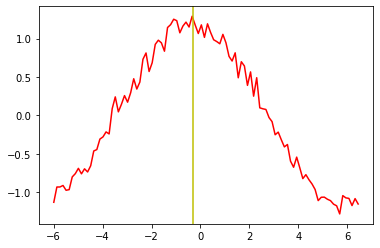

In [50]:
fig, ax = plt.subplots()

ax.plot(x+theta[-1],cost,'r-')
ax.axvline(x=b, color = 'y')

In [56]:
reload(smo)
# theta = np.random.rand(vqs.np)
theta = np.zeros(vqs.np)
n_iter = 100
theta, cost = smo.sequential_opt(vqs, theta, n_iter = n_iter, n_samples = 10**4)

In [57]:
state = vqs.return_state()

# theta = np.random.rand(vqs.np)
params = {vqs.p[i] : theta[n_iter-1,i] for i in range(vqs.np)}
state = state.bind_parameters(params)

state_ = np.array(Statevector(state))

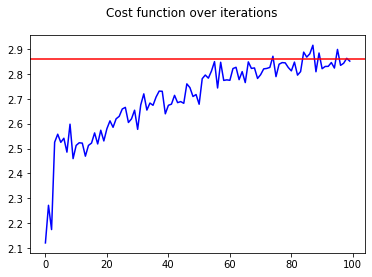

In [58]:
fig, ax = plt.subplots()

fig.suptitle('Cost function over iterations')
ax.plot(np.arange(n_iter), cost, 'b-')
ax.axhline(BM.dot(bm),color = 'r')

In [60]:
print(f"inner product between exact and variational state : {state_.dot(BM)}")

inner product between exact and variational state : (0.9953493567121308+0j)


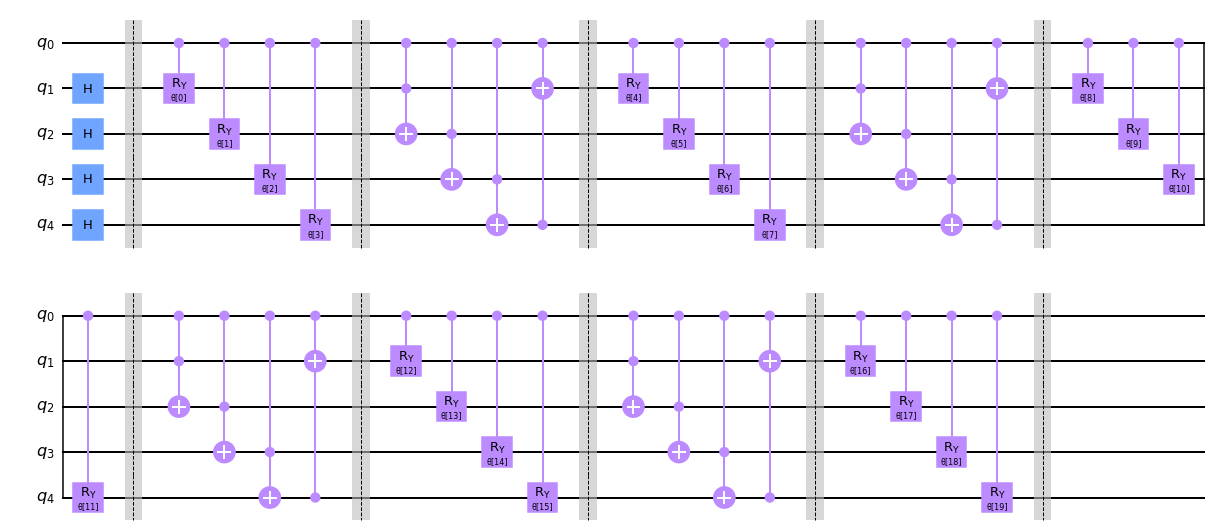

In [55]:
vqs.G.draw('mpl')

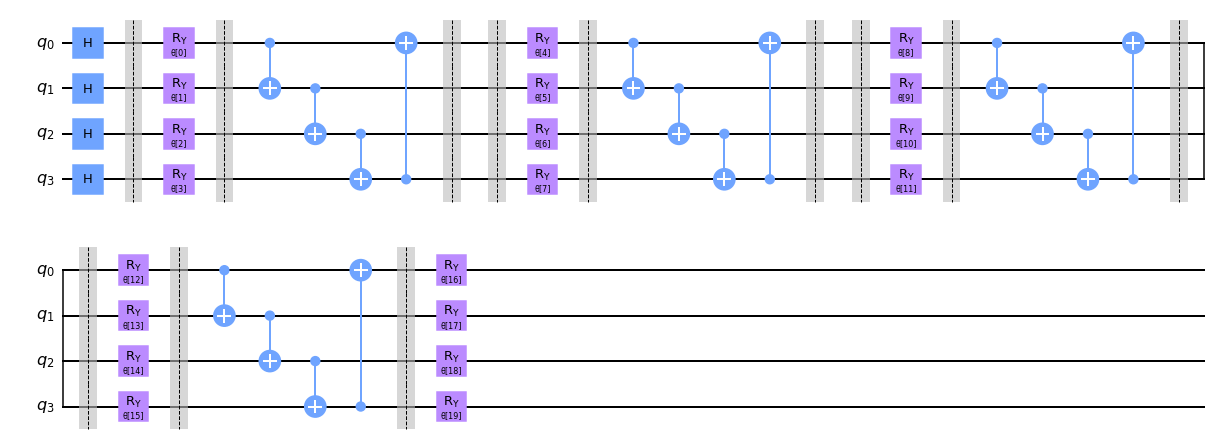

In [44]:
vqs.return_state().draw('mpl')